<h1 style="text-align:center;">Анализ капитализации крупнейших мировых бирж и обработка данных котировок акций</h1>

**Автор**: Дарья Авдеёнок. Совместная программа по экономике ВШЭ-РЭШ, второй курс.

В рамках проекта было сформулировано и успешно решено средствами Python две основные задачи:

1. **Проанализировать крупнейшие биржи и их месторасположение.**
Задача разбилась на следующие подзадачи:

- Получить данные с веб-страницы о крупнейших биржах. 
- Выполнить необходимый препроцессинг данных (выяснить структуру, удалить невалидные значения, сделать преобразование текстовых данных в численные).
- Построить капитализацию каждой биржи на диаграмме.
- Построить на интерактивной карте метки городов, в которых базируются биржи.
- Для каждой страны посчитать суммарную капитализацию бирж, которые в ней располагаются. Построить heatmap-график с отметками бирж.

2. **Анализ временных рядов акций с помощью линейной регрессии. Выделение компаний, чьи акции растут, когда в среднем рынок падает.**

Для характеристики ситуации на мировом рынке применяются различные индексы, которые рассчитываются на основе показателей множества компаний. Одним из известных является индекс S&P 500. Он отражает взвешенное среднее стоимости акций крупнейших 500 компаний (веса берутся относительно доли капитализации компании). S&P 500 может помочь выделить одну из ситуаций "bull market" или "bear market", т.е. растет или падает рынок в среднем.

Нашей задачей будет за последние 2 года выделить непересекающиеся промежутки времени в 21 день, где индекс S&P 500  убывал более всего. И посмотреть акции каких компаний сильнее всего росли в эти периоды. Для оценки "скорости роста" будет использован коэффициент из линейной регресии на необходимом периоде.

Выделение подобных компаний и их последующий анализ может помочь игрокам биржи обратить внимание на корпорации, которые мало зависят от динамики глобального рынка и, следовательно, более надёжны для инвестирования.

Этапы решений второй подзадачи:

- скачать с веб-страницы информацию о текущих компаниях в S&P 500.
- скачать данные о катировках акций 500 компаний и S&P 500 индекса за последние 2 года.
- Реализовать линейную регрессию с помощью numpy (хотя можно вопсользоваться готовыми пакетами).
- Выделить непересекающиеся промежутки времени, когда индекс сильнее всего убывает.
- Проанализировать акции 500-та компаний на этих промежутках и выделить топ 3, чьи акции лушче всего росли.
- Построить соответствующие графики стоимостей акций.



**Использованные технологии**

- <u>Работа с DataFrame и Series в pandas</u>: read_html, loc, concat, rename, apply, astype, dropna, sort_values, slicing, iterrows, index, groupby, sum, append, plot, merge, join, rolling, фильтрация строк.


- <u>Анализ веб-страниц</u>: два набора данных были получены путём анализа веб-страниц с помощью обёртки lxml в pandas.


- <u>Обработка геоданных и построение графиков с ними</u>: ипользовались geopandas, geopy, pycountry и folium. Написаны фукнции, которые по названию города могут определить код страны, в котором он находится, и его gps координаты. Построены интерактивные и статичные графики.


- <u>Обработка и парсинг строк</u>: несколько раз применена библиотека regular expression для обработки текстовых данных, а также стандартные методы класcа str.


- <u>Скачивание финансовых данных</u>: используется интерфейс yahoo.finance для загрузки данных об акциях различных компаний (заметим, что у пакета нет открытой документации).


- <u>Обработка данных в numpy</u>: с помощью numpy реализована одномерная линейная регрессия.


- <u>Работа с датами</u>: для обработки временных рядов использован пакет datetime.


- <u>Построение графиков</u>: активно использованы различные возможности matplotlib.


**Общий объём кода без учёта комментариев: около 230 строк.**


In [22]:
import pandas as pd
from datetime import date, datetime, timedelta
import numpy as np
from IPython.display import display   # визуализация таблиц в pandas
import yfinance as yf                 # yahoo finance
import matplotlib.pyplot as plt
import csv
import re                             # regular expression
import folium                         # интерактивные карты
from geopy.geocoders import Nominatim # поиск координат городов и стран по названиям
import pycountry
import geopandas as gpd               # обработка и храниние геоданных
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams['figure.dpi'] = 400

<h1 style="text-align:center;">Часть 1: анализ крупнейших бирж и их расположения</h1>

In [2]:
# Загрузим открытые данные о капитализации и расположении бирж
url_stocks = 'https://en.wikipedia.org/wiki/List_of_stock_exchanges'
raw_data = pd.read_html(url_stocks)[1]  # берём таблицу после анализа web-страницы c данными крупнейших бирж

In [3]:
display(raw_data)

#  Year  \
                            #  Year   
0                         NaN   NaN   
1                           1  2022   
2                           2  2022   
3                           3  2022   
4                           4  2022   
5                           5  2022   
6                           6  2022   
7                           7  2022   
8                           8  2022   
9                           9  2022   
10                         10  2022   
11                         11  2022   
12                         12  2022   
13                         13  2022   
14                         14  2022   
15                         14  2022   
16                         14  2022   
17             Stock exchange   MIC   
18             Stock exchange   MIC   
19  Copenhagen Stock Exchange  XCSE   
20   Stockholm Stock Exchange  XSTO   
21    Helsinki Stock Exchange  XHEL   
22     Tallinn Stock Exchange  XTAL   
23        Riga Stock Exchange  XRIS   
24     Vilnius Stock Exchange  XLIT   
25     Iceland Stock Exchange  XICE   
26                         15  2022   
27                         16  2022   
28                         17  2022   
29                         18  2022   
30                         19  2022   
31                         20  2022   

                                       Stock exchange  \
                                       Stock exchange   
0                                                 NaN   
1                             New York Stock Exchange   
2                                              Nasdaq   
3                             Shanghai Stock Exchange   
4                                            Euronext   
5                                Japan Exchange Group   
6                             Shenzhen Stock Exchange   
7                            Hong Kong Stock Exchange   
8                               Bombay Stock Exchange   
9                               London Stock Exchange   
10                            National Stock Exchange   
11                             Toronto Stock Exchange   
12                     Saudi Stock Exchange (Tadawul)   
13                                 SIX Swiss Exchange   
14                                  Deutsche Börse AG   
15                 Nasdaq Nordic and Baltic Exchanges   
16  Stock exchanges Stock exchange MIC Region Mark...   
17                                             Region   
18                                             Region   
19                                            Denmark   
20                                             Sweden   
21                                            Finland   
22                                            Estonia   
23                                             Latvia   
24                                          Lithuania   
25                                            Iceland   
26                     Australian Securities Exchange   
27                                     Korea Exchange   
28                        Johannesburg Stock Exchange   
29                              Taiwan Stock Exchange   
30                              Tehran Stock Exchange   
31                             B3 Brasil Bolsa Balcão   

                                                  MIC  \
                                                  MIC   
0                                                 NaN   
1                                                XNYS   
2                                                XNAS   
3                                                XSHG   
4                        XAMSXBRUXMSMXLISXMILXOSLXPAR   
5                                                XJPX   
6                                                XSHE   
7                                                XHKG   
8                                                XBOM   
9                                                XLON   
10                                               XNSE   
11                   

In [4]:
# обрезаем нужные строки, которые правильно скопировались
df_1 = raw_data.loc[1:15]
df_2 = raw_data.loc[26:31]
df_stocks = pd.concat([df_1, df_2], axis=0)

df_stocks = pd.concat([df_stocks[col1][col2] for col1, col2 in list(df_stocks.columns)], axis=1)

# переименовываем название колонки с капитализацией
df_stocks = df_stocks.rename(columns={'Market cap(USD\xa0tn)': 'Market cap'})

# убираем любые лишние символы в строке, где должны быть числа float
def clear_digits(string):
    return re.sub(r'[^0-9.]', '', string)

# Преобразуем данные о капитализации в float
df_stocks['Market cap'] = df_stocks['Market cap'].apply(clear_digits)
df_stocks['Market cap'] = df_stocks['Market cap'].astype(float)

display(df_stocks)

,#,Year,Stock exchange,MIC,Region,Market place,Market cap,Monthly trade volume(USD bn),Time zone,Δ,DST,Open,Close,Lunch,Open,Close
1,1,2022,New York Stock Exchange,XNYS,United States,New York City,22.70,1452,EST/EDT,−5:00,Mar–Nov,09:30,16:00,No,14:30,21:00
2,2,2022,Nasdaq,XNAS,United States,New York City,18.00,1262,EST/EDT,−5:00,Mar–Nov,09:30,16:00,No,14:30,21:00
3,3,2022,Shanghai Stock Exchange,XSHG,China,Shanghai,7.26,536,CST,+8:00,NaN,09:30,15:00,11:30–13:00,01:30,07:00
4,4,2022,Euronext,XAMSXBRUXMSMXLISXMILXOSLXPAR,Europe,AmsterdamBrusselsDublinLisbonMilanOsloParis,6.62,174,CET/CEST,+1:00,Mar–Oct,09:00,17:30,No,08:00,16:30
5,5,2022,Japan Exchange Group,XJPX,Japan,Tokyo,5.65,NaN,JST,+9:00,NaN,09:00,15:00,11:30–12:30,00:00,06:00
6,6,2022,Shenzhen Stock Exchange,XSHE,China,Shenzhen,5.20,NaN,CST,+8:00,NaN,09:30,15:00,11:30–13:00,01:30,07:00
7,7,2022,Hong Kong Stock Exchange,XHKG,Hong Kong,Hong Kong,4.97,182,HKT,+8:00,NaN,09:30,16:00,12:00–13:00,01:30,08:00
8,8,2022,Bombay Stock Exchange,XBOM,India,Mumbai,3.50,NaN,IST,+5:30,NaN,09:15,15:30,No,03:45,10:00
9,9,2022,London Stock Exchange,XLON,United Kingdom,London,3.27,219,GMT/BST,+0:00,Mar–Oct,08:00,16:30,No,08:00,16:30
10,10,2022,National Stock Exchange,XNSE,India,Mumbai,3.20,481,IST,+5:30,NaN,09:15,15:30,No,03:45,10:00


In [5]:
# вытягиваем список городов, в которых находятся биржи
# учитываем, что одна биржа может быть представлена сразу в нескольких городах
def split_string(text):
    words = re.findall('[A-Z][a-z]*', text)
    return words

cities_raw = df_stocks['Market place'].tolist()
cities = []
for elem in cities_raw:
    if ' ' not in elem:
        cities += split_string(elem)
    else:
        cities.append(elem)
        
cities = list(set(cities))
print(cities)

['Dublin', 'Busan', 'Amsterdam', 'Toronto', 'Hong Kong', 'New York City', 'Tehran', 'London', 'Lisbon', 'São Paulo', 'Brussels', 'Europe', 'Sydney', 'Paris', 'Shenzhen', 'Shanghai', 'Johannesburg', 'Tokyo', 'Oslo', 'Zurich', 'Mumbai', 'Frankfurt', 'Seoul', 'Taipei', 'Milan', 'Riyadh']


In [6]:
# распознаём широту и долготу каждого города с помощью geopy для нанесения на карту
geolocator = Nominatim(user_agent="my_geocoder")

gps_cities = {'longitude' : [], 'latitude' : [], 'city' : []}

for i, city in enumerate(cities):
    location = geolocator.geocode(city)
    gps_cities['longitude'].append(location.longitude)
    gps_cities['latitude'].append(location.latitude)
    gps_cities['city'].append(city)

In [7]:
# инициализируем карту folium
m = folium.Map(location=[0, 180], zoom_start=1)

# Данные о точках: долгота, широта и подписи
locations = []
for i in range(len(gps_cities['city'])):
    locations.append({'lon' : gps_cities['longitude'][i], 'lat' : gps_cities['latitude'][i],\
                      'name' :gps_cities['city'][i] })

# Добавление маркеров на карту
for loc in locations:
    folium.Marker([loc['lat'], loc['lon']], popup=loc['name']).add_to(m)

display(m)

In [8]:
# по названию страны подбирает её iso_a3 кодировку
def get_country_code(country_name):
    try:
        country = pycountry.countries.search_fuzzy(country_name)[0]
        return country.alpha_3
    except LookupError:
        return None

# поиск названия страны по городу, который в ней
def city2country(city_name):
    geolocator = Nominatim(user_agent='my-app')
    location = geolocator.geocode(city_name, language='en')
    
    # парсинг адреса
    full_address = location.address
    last_comma_index = full_address.rfind(',')
    if last_comma_index != -1:
        result = full_address[last_comma_index + 1 : ].strip()
    else:
        result = full_address
        
    return result

In [9]:
# Выведем крупнейшие биржи, существующие в рамках одной страны, с названием и их капитализацией
columns_to_unite = ['Stock exchange', 'Region', 'Market cap']
df_countries_cap = pd.concat([df_stocks[col] for col in columns_to_unite], axis=1)

df_countries_cap['Region'] = df_countries_cap['Region'].apply(get_country_code)
df_countries_cap = df_countries_cap.dropna()
df_countries_cap = df_countries_cap.sort_values('Market cap', ascending = False)
display(df_countries_cap.T)

,1,2,3,5,6,7,8,9,10,11,12,13,14,26,27,28,29,30,31
Stock exchange,New York Stock Exchange,Nasdaq,Shanghai Stock Exchange,Japan Exchange Group,Shenzhen Stock Exchange,Hong Kong Stock Exchange,Bombay Stock Exchange,London Stock Exchange,National Stock Exchange,Toronto Stock Exchange,Saudi Stock Exchange (Tadawul),SIX Swiss Exchange,Deutsche Börse AG,Australian Securities Exchange,Korea Exchange,Johannesburg Stock Exchange,Taiwan Stock Exchange,Tehran Stock Exchange,B3 Brasil Bolsa Balcão
Region,USA,USA,CHN,JPN,CHN,HKG,IND,GBR,IND,CAN,SAU,CHE,DEU,AUS,KOR,ZAF,TWN,IRN,BRA
Market cap,22.7,18.0,7.26,5.65,5.2,4.97,3.5,3.27,3.2,3.02,2.7,1.71,1.7,1.55,1.49,1.36,1.26,1.05,0.85


In [10]:
# сформируем DataFrame, в котором будет посчитана суммарная капитализация бирж для каждой страны, 
# в которой они располагаются

columns_to_unite = ['Market place', 'Market cap']
df_cap_by_city = pd.concat([df_stocks[col] for col in columns_to_unite], axis=1)

df_cap_split = pd.DataFrame(columns=['Place', 'Cap'])

# смотрим биржи по городам, если одна биржа присутствует в нескольких странах, то учитываем её капитализацию
# в каждой стране-участнике
for index, row in df_cap_by_city.iterrows():
    city = row['Market place']
    if ' ' in city:
        res = [city]
    else:
        res = split_string(row['Market place'])
    
    for elem in res:
#         temp = {'Place' : elem, 'Cap' : (row['Market cap'] / len(res))}
        temp = {'Place' : elem, 'Cap' : (row['Market cap'])}
        df_cap_split = df_cap_split.append(temp, ignore_index=True)

# округляем до двух знаков после запятой
df_cap_split['Cap'] = df_cap_split['Cap'].round(2)

# по городу распознаём страну и далее её ico3 индекс
df_cap_split['Place'] = df_cap_split['Place'].apply(city2country)
df_cap_split['Place'] = df_cap_split['Place'].apply(get_country_code)
df_cap_split = df_cap_split.dropna()


# суммируем капитализации всех бирж входящих в одну страну и сортируем по убыванию
df_cap_split = df_cap_split.groupby('Place').sum()
df_cap_split = df_cap_split.sort_values('Cap', ascending=False)
display(df_cap_split.T)

Place,USA,CHN,IND,IRL,NOR,NLD,ITA,BEL,PRT,FRA,...,CAN,KOR,SAU,CHE,DEU,AUS,ZAF,TWN,IRN,BRA
Cap,40.7,17.43,6.7,6.62,6.62,6.62,6.62,6.62,6.62,6.62,...,3.02,2.98,2.7,1.71,1.7,1.55,1.36,1.26,1.05,0.85


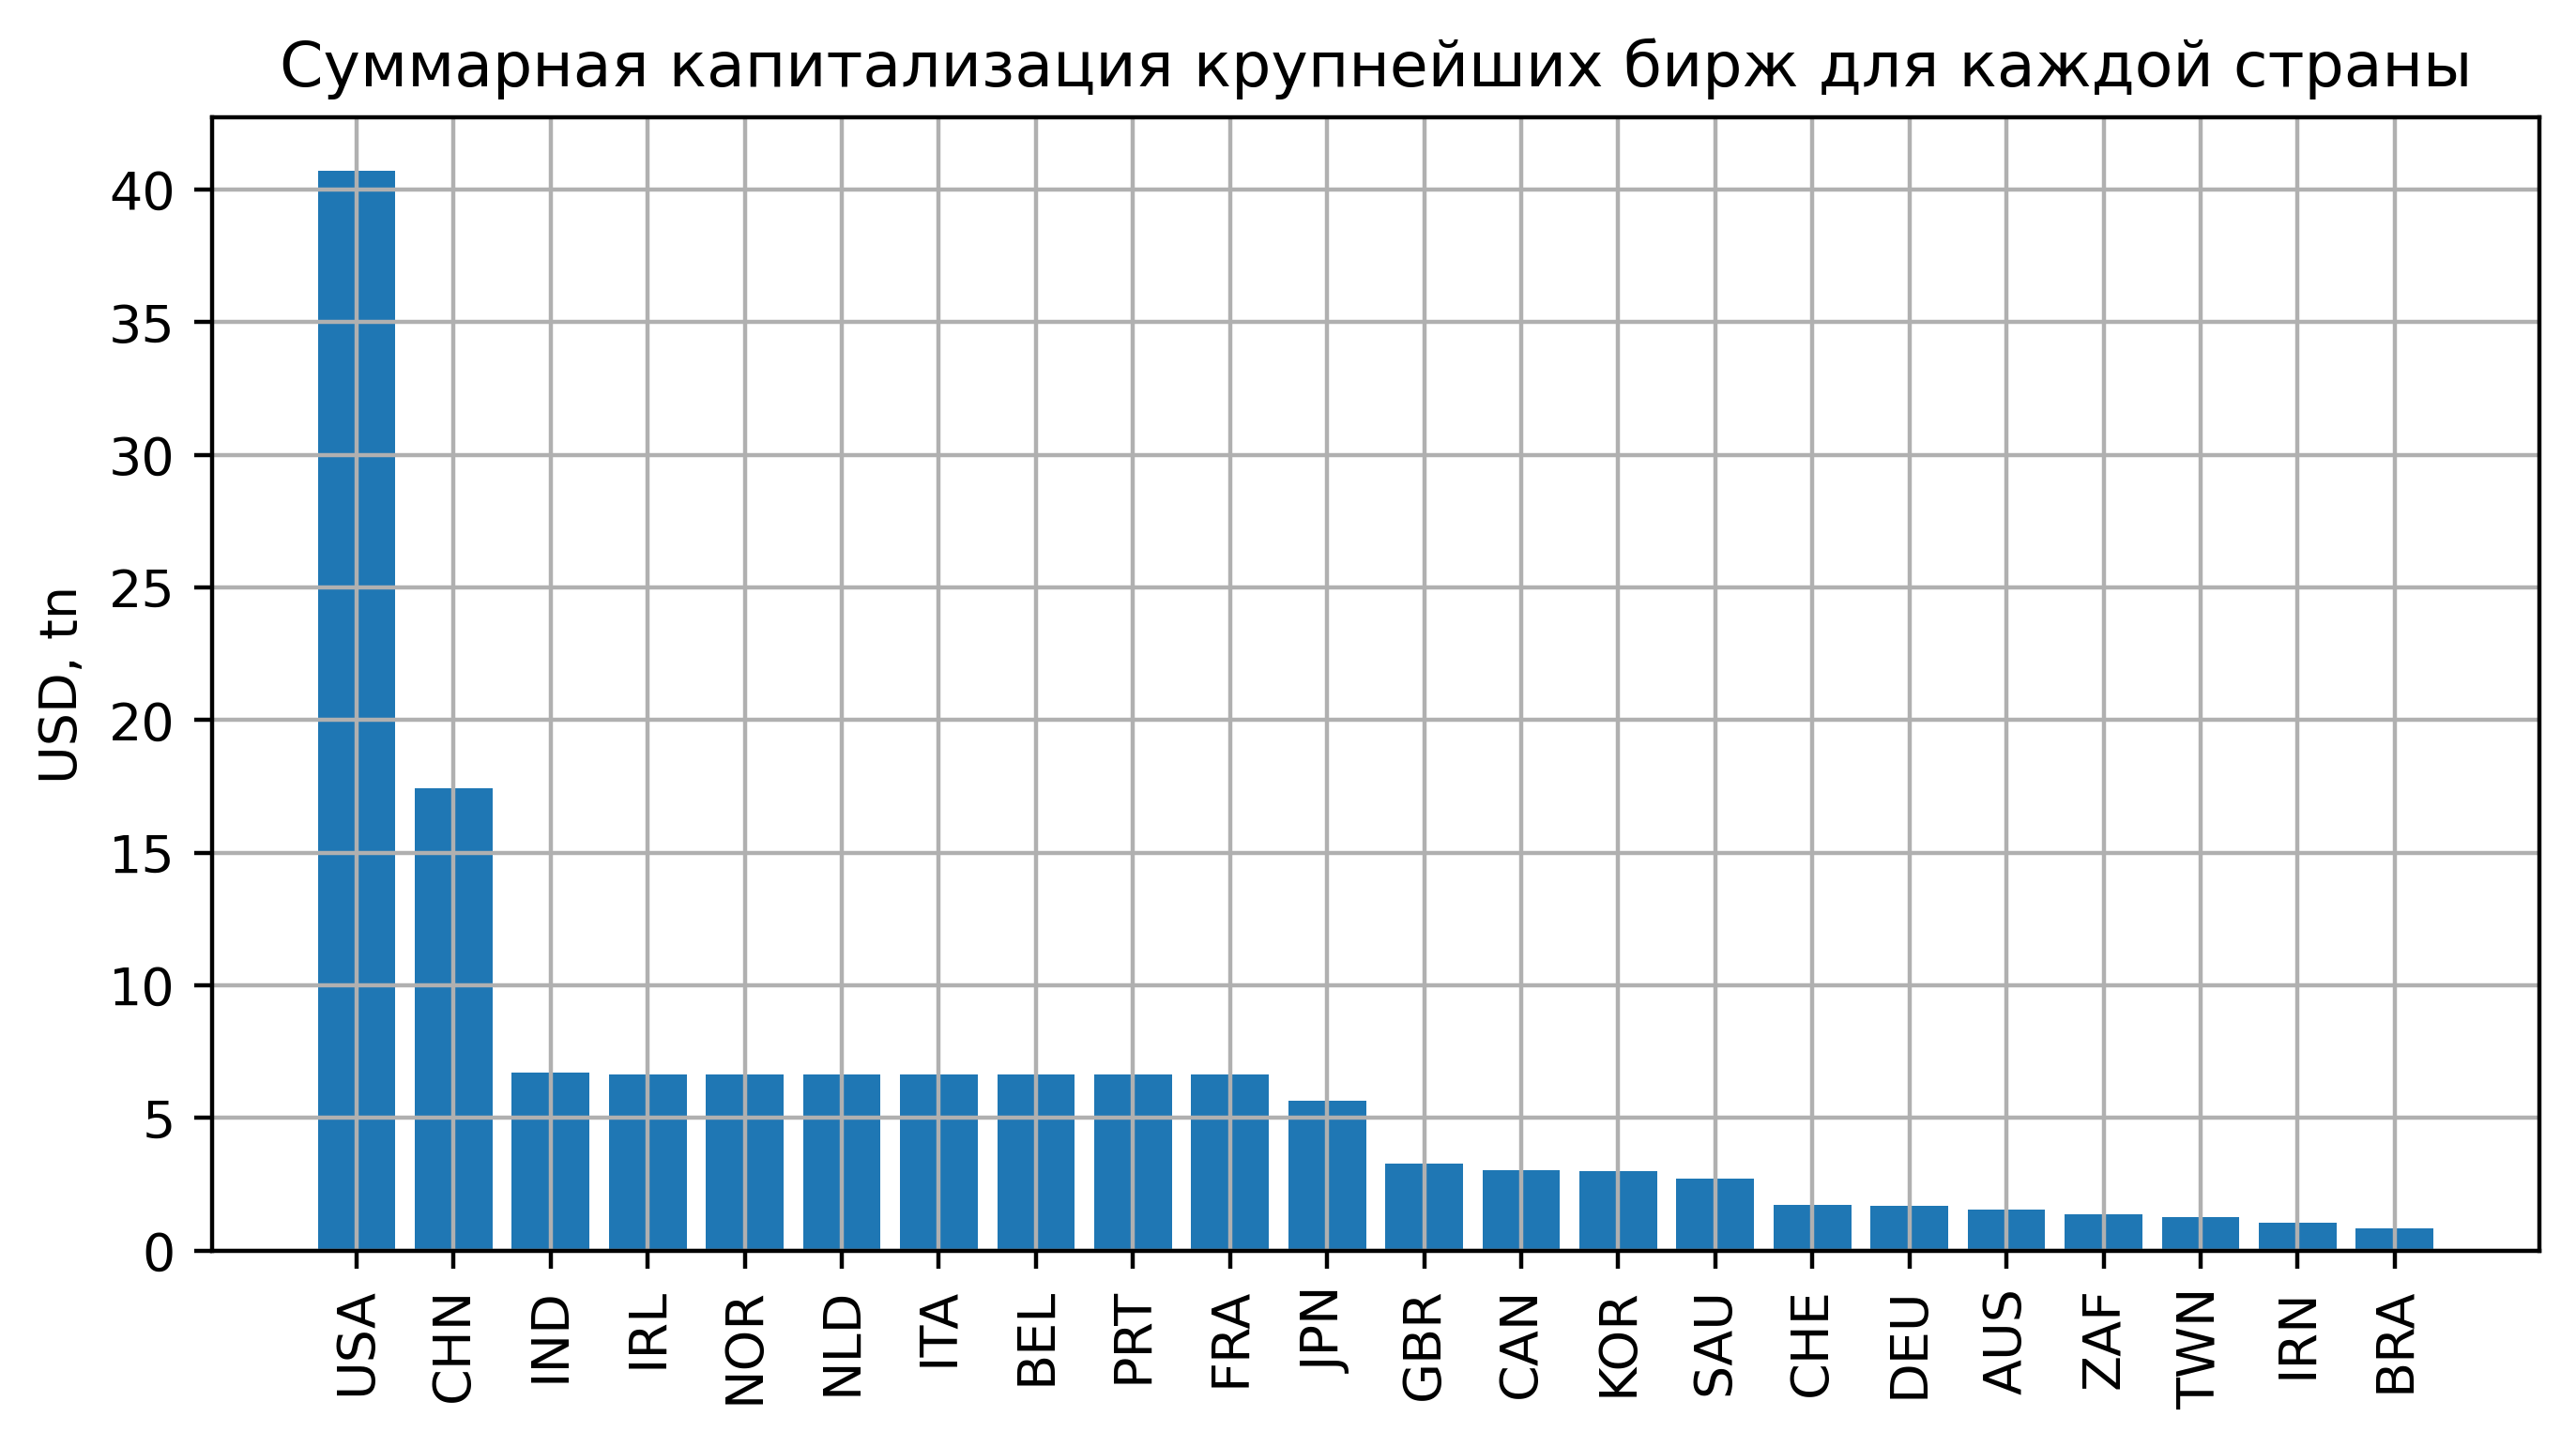

In [40]:
# изобразим данные на диаграмме
fig, ax = plt.subplots(figsize=(8, 4))
plt.bar(df_cap_split.index, df_cap_split['Cap'])
plt.xticks(rotation=90)
plt.title('Суммарная капитализация крупнейших бирж для каждой страны')
plt.ylabel('USD, tn')
plt.grid()

/tmp/ipykernel_132039/4106908112.py:8: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


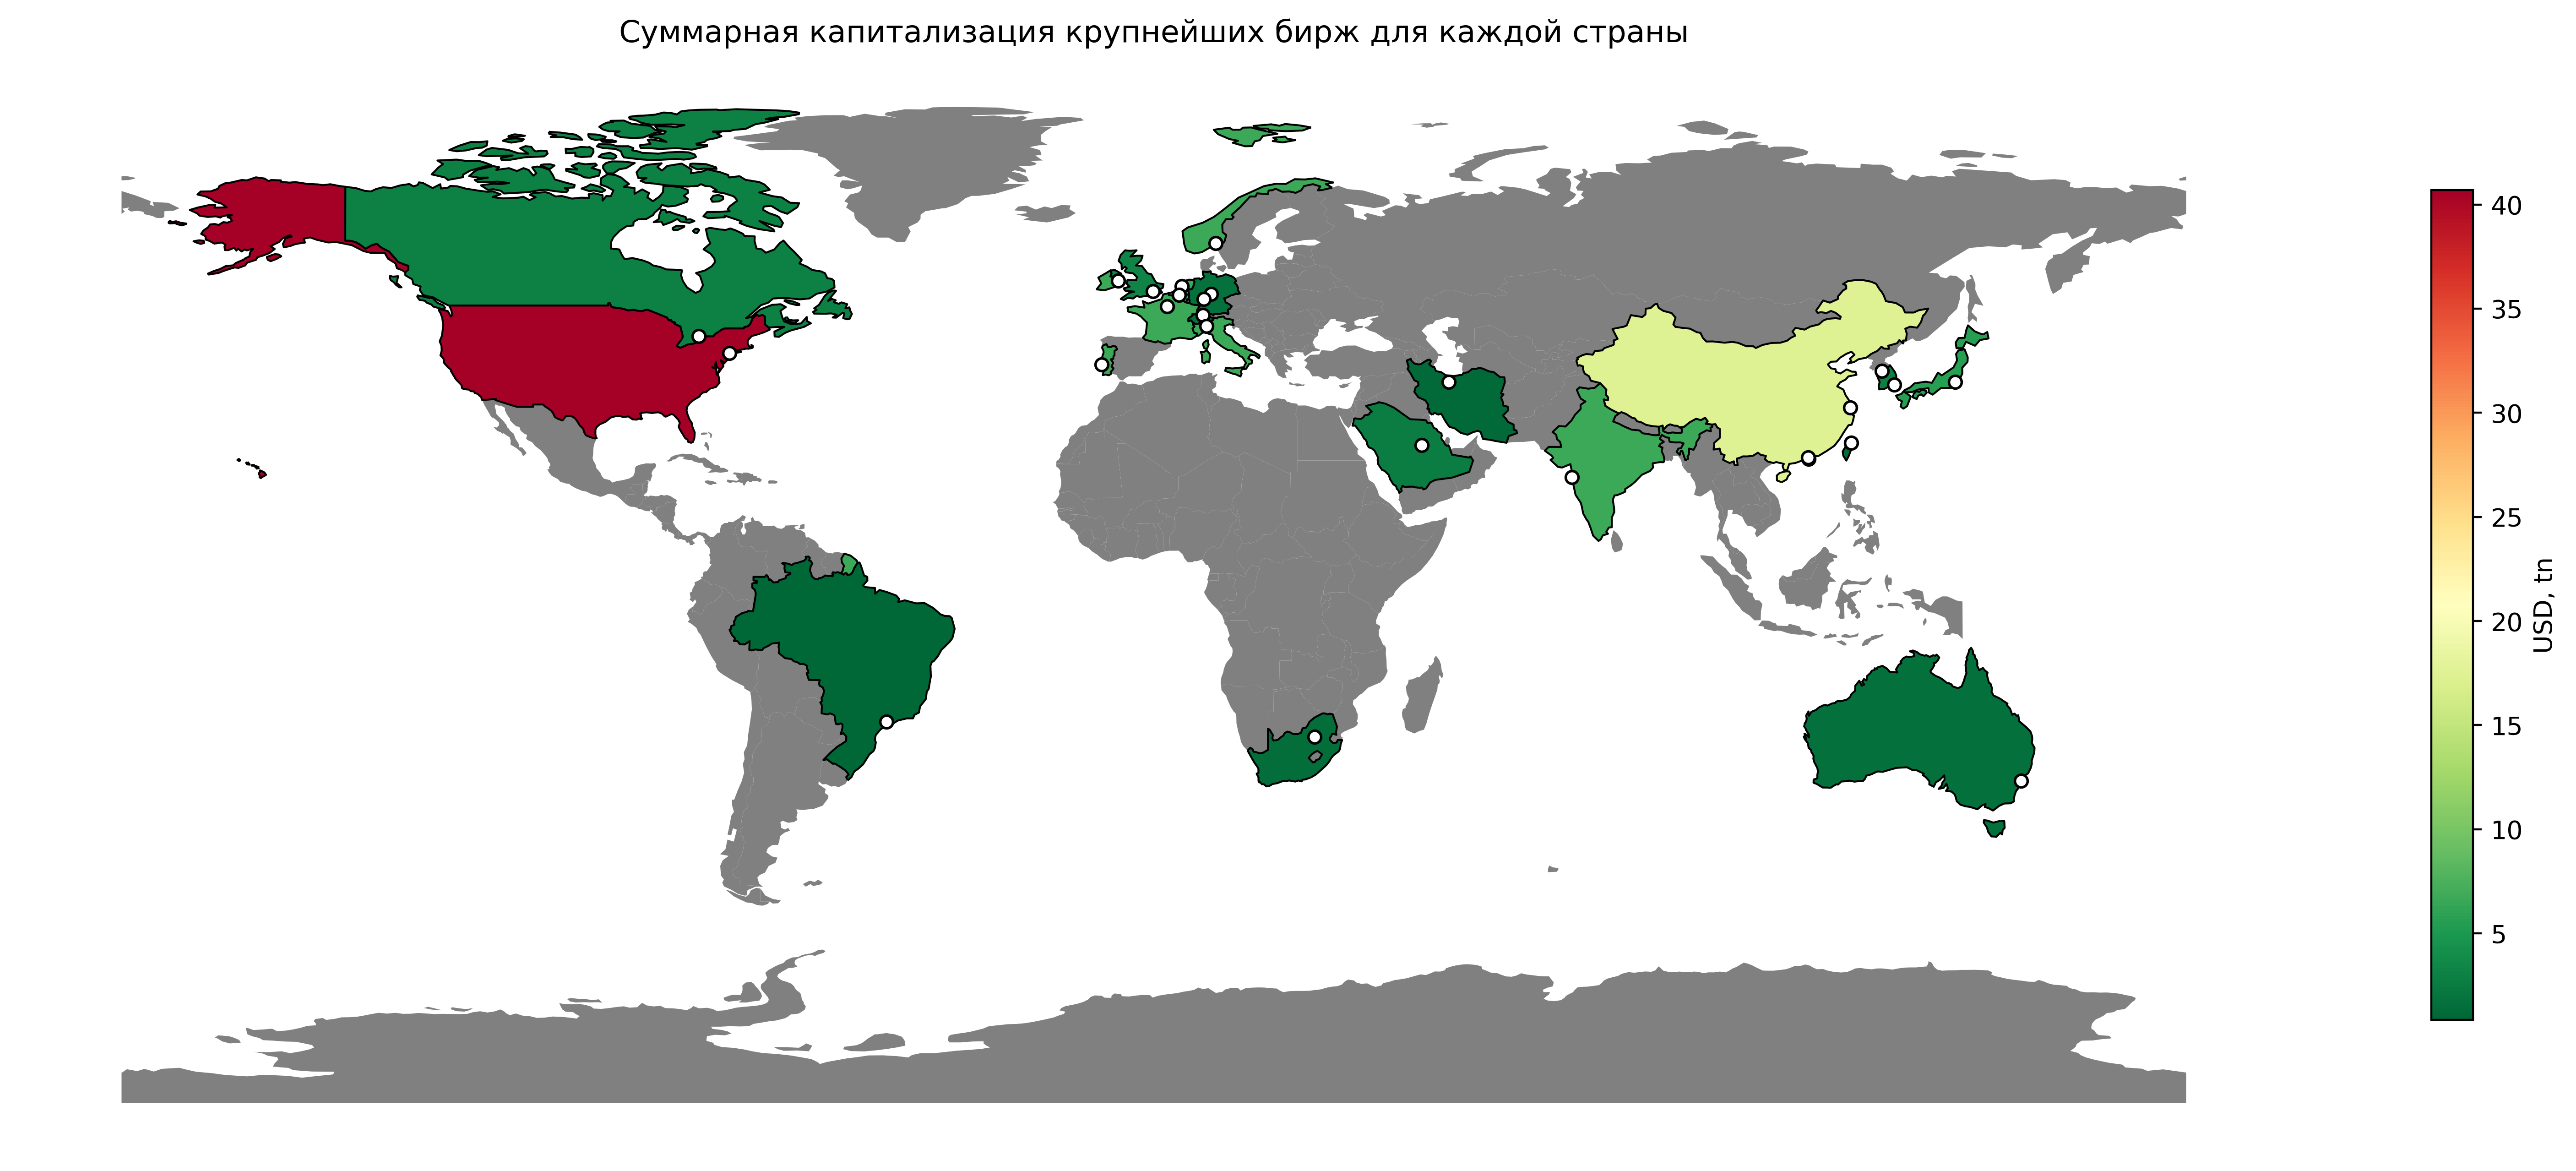

In [41]:
# Теперь сформируем GeoDataFrame и нанесём его на карту
gps_cities_dict = {'longitude' : gps_cities['longitude'], 'latitude' : gps_cities['latitude']}
gdf = gpd.GeoDataFrame(gps_cities, geometry = gpd.points_from_xy(gps_cities['longitude'], gps_cities['latitude']))

fig, ax = plt.subplots(figsize=(20, 20))

# загружаем границы стран и добавляем цвет
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world[world['continent'] != 'Oceania'].plot(ax=ax, color='grey')
# Австралия в картах помечена как остров, поэтому отдельно задаём её цвет
australia = world[world['name'] == 'Australia']
australia.plot(ax=ax, color='grey')

### FROM : https://geopandas.org/en/stable/gallery/choropleths.html
#          https://geopandas.org/en/stable/docs/user_guide/mapping.html

# по ico3 коду каждой страны сопоставляем ей геометку
merged_data = world.merge(df_cap_split, left_on='iso_a3', right_on='Place', how='left')

merged_data.plot(column='Cap', ax = ax, legend = True, linewidth = 0.75, edgecolor = 'Black',
                 legend_kwds={"label": "USD, tn", "shrink":.3}, cmap="RdYlGn_r")
### END FROM

# Отрисуем в виде точек на карте места расположения бирж
gdf.plot(ax = plt.gca(), marker = 'o', color = 'white', markersize = 25, edgecolor = 'black')

ax.set_title('Суммарная капитализация крупнейших бирж для каждой страны')
ax.axis('off')

plt.show()

<h1 style="text-align:center;">Часть 2: анализ временных рядов</h1>

In [13]:
# Загружаем с веб-страницы S&P500 компании
sp_df = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp_df['Symbol'] = sp_df['Symbol'].str.replace('.', '-',regex = True)
sp_ticker = '^GSPC'   # индекс S&P 500
tickers = [sp_ticker] + list(sp_df['Symbol'])[:]

# скачивание данных по батчам, фактические цены акций на время закрытия биржи
df_price = pd.DataFrame()
batch = 40
loop_sz = int(len(tickers) // batch) + 2

for t in range(1, loop_sz):
    beg = (t - 1) * batch
    end = t * batch
    batch_list = tickers[beg : end]
    batch_temp = yf.download(tickers = batch_list, start = '2010-01-01', end = None, 
                                 interval = "1d", group_by = 'column', auto_adjust = True, 
                                 prepost = True, proxy = None)['Close']
    df_price = df_price.join(batch_temp, how = 'outer')

[*********************100%***********************]  40 of 40 completed
[*********************100%***********************]  40 of 40 completed
[*********************100%***********************]  40 of 40 completed
[*********************100%***********************]  40 of 40 completed
[*********************100%***********************]  40 of 40 completed
[*********************100%***********************]  40 of 40 completed
[*********************100%***********************]  40 of 40 completed
[*********************100%***********************]  40 of 40 completed
[*********************100%***********************]  40 of 40 completed
[*********************100%***********************]  40 of 40 completed
[*********************100%***********************]  40 of 40 completed
[*********************100%***********************]  40 of 40 completed
[*********************100%***********************]  24 of 24 completed


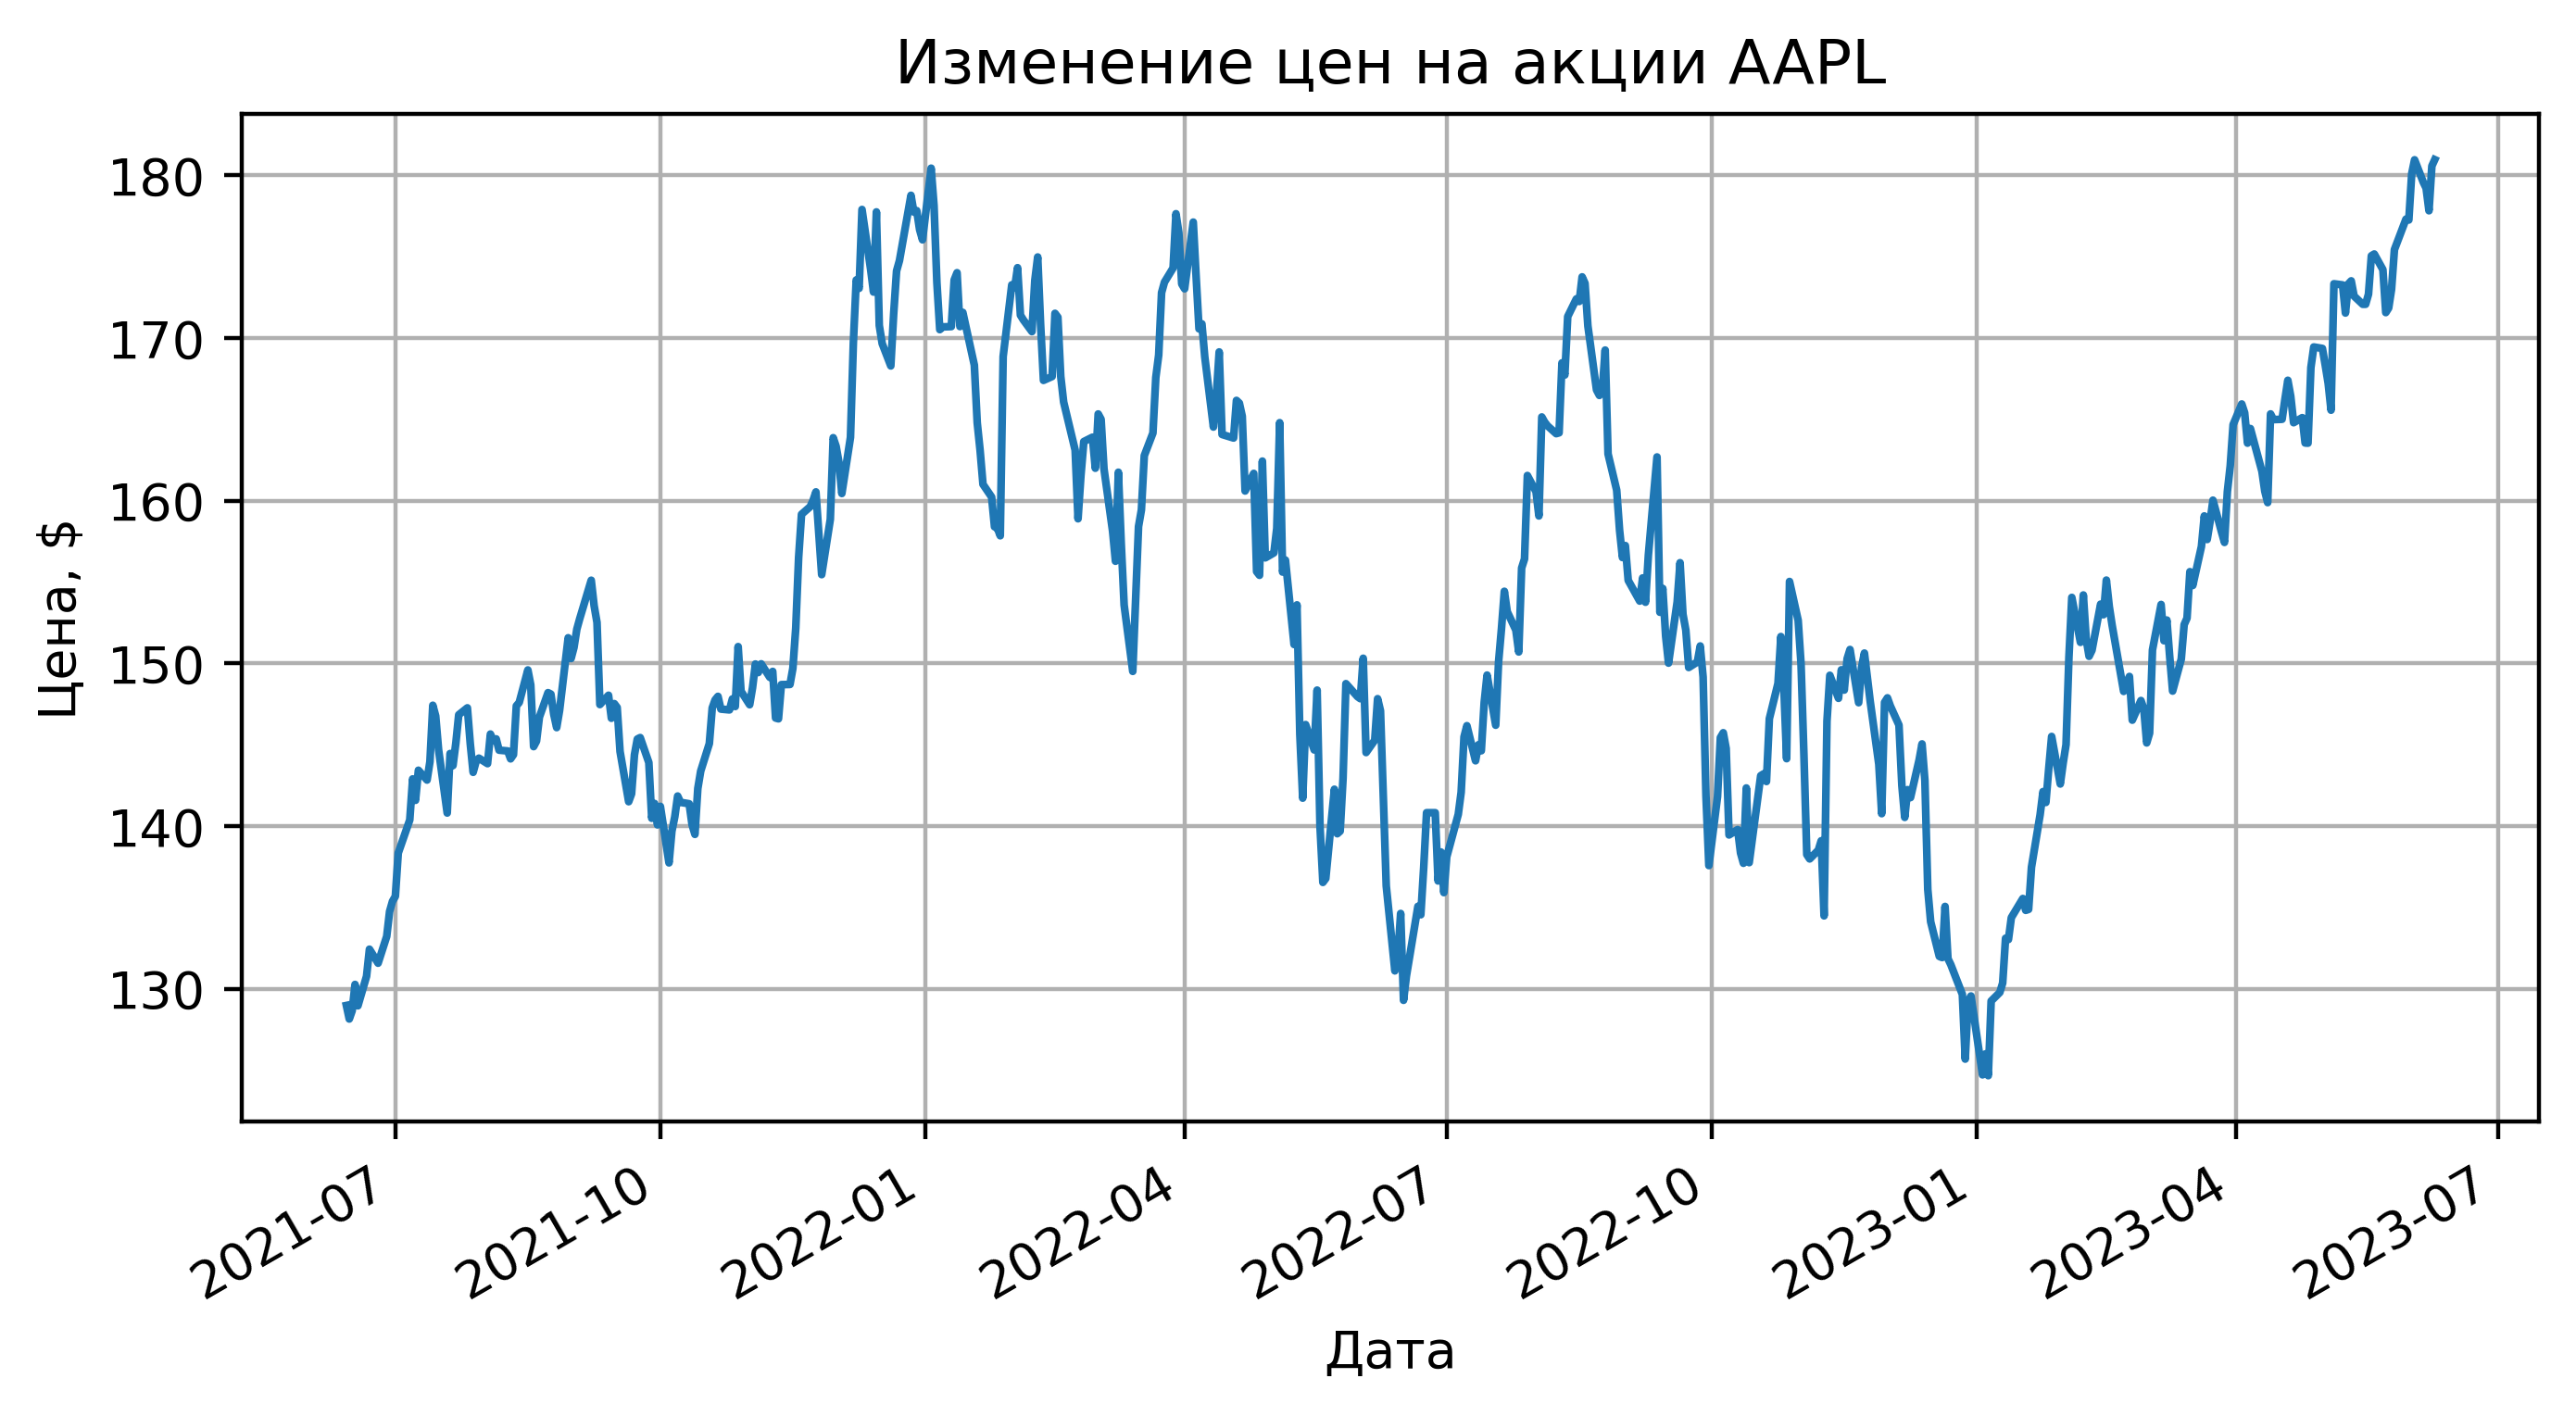

In [42]:
# Построим график акций определённой компании для демонстрации
company = 'AAPL'   # Apple
df_price[company].plot(figsize=(8, 4))
plt.title('Изменение цен на акции ' + company)
plt.xlabel('Дата')
plt.grid()
plt.ylabel('Цена, $')
plt.show()

In [43]:
# рассмотри только последние 2 года, как актуальную информацию о компаниях
two_years_ago = datetime.today() - timedelta(days = 365 * 2)
df_price = df_price[df_price.index > two_years_ago]

Для анализа скорости убывания или возростания на временном интервале воспользуемся коэффициентом наклона прямой после решения задачи наименьших квадратов. Данный материал хорошо описан в [статье](https://habr.com/ru/articles/514818/) на Habr и всех классических учебниках по мат. статистике.


Решение задачи одномерной линейной регрессии являются параметры прямой, минимизирующей фукнционал:

$$
f(a, b) = \sum\limits_{k = 1}^N
\left\|
(a \cdot x_i - b) - y_i
\right\|^2
\to \min
$$

Где $(x_i, y_i)$ это точки, получаемые из данных. Решением данной задачи является:

$$
a = \frac{\langle x * y \rangle - \langle x\rangle \langle y\rangle}{\langle x^2\rangle - \langle x\rangle^2}
$$

Где $\langle x\rangle$ это средняя величина, а $x * y$ поэлементное произведение векторов.
Коэффициент $a$ является попыткой аппроксимировать среднее значение стохастической производной в определённый момент времени, если рассматривать тренд акции, как случайный процесс.

In [24]:
# одномерная линейная регрессия
def optimal_fit(series):
    """
    возвращает коэффициет a из оптимальной прямой (a * x + b), являющейся решением МНК
    """
    y = series.values
    x = np.arange(len(y))
    
    x_mean = np.average(x)
    y_mean = np.average(y)
    x_sq_mean = np.average(np.square(x))
    xy_mean = np.average(x * y)
    k = (xy_mean - x_mean * y_mean) / (x_sq_mean - x_mean**2)
    return k

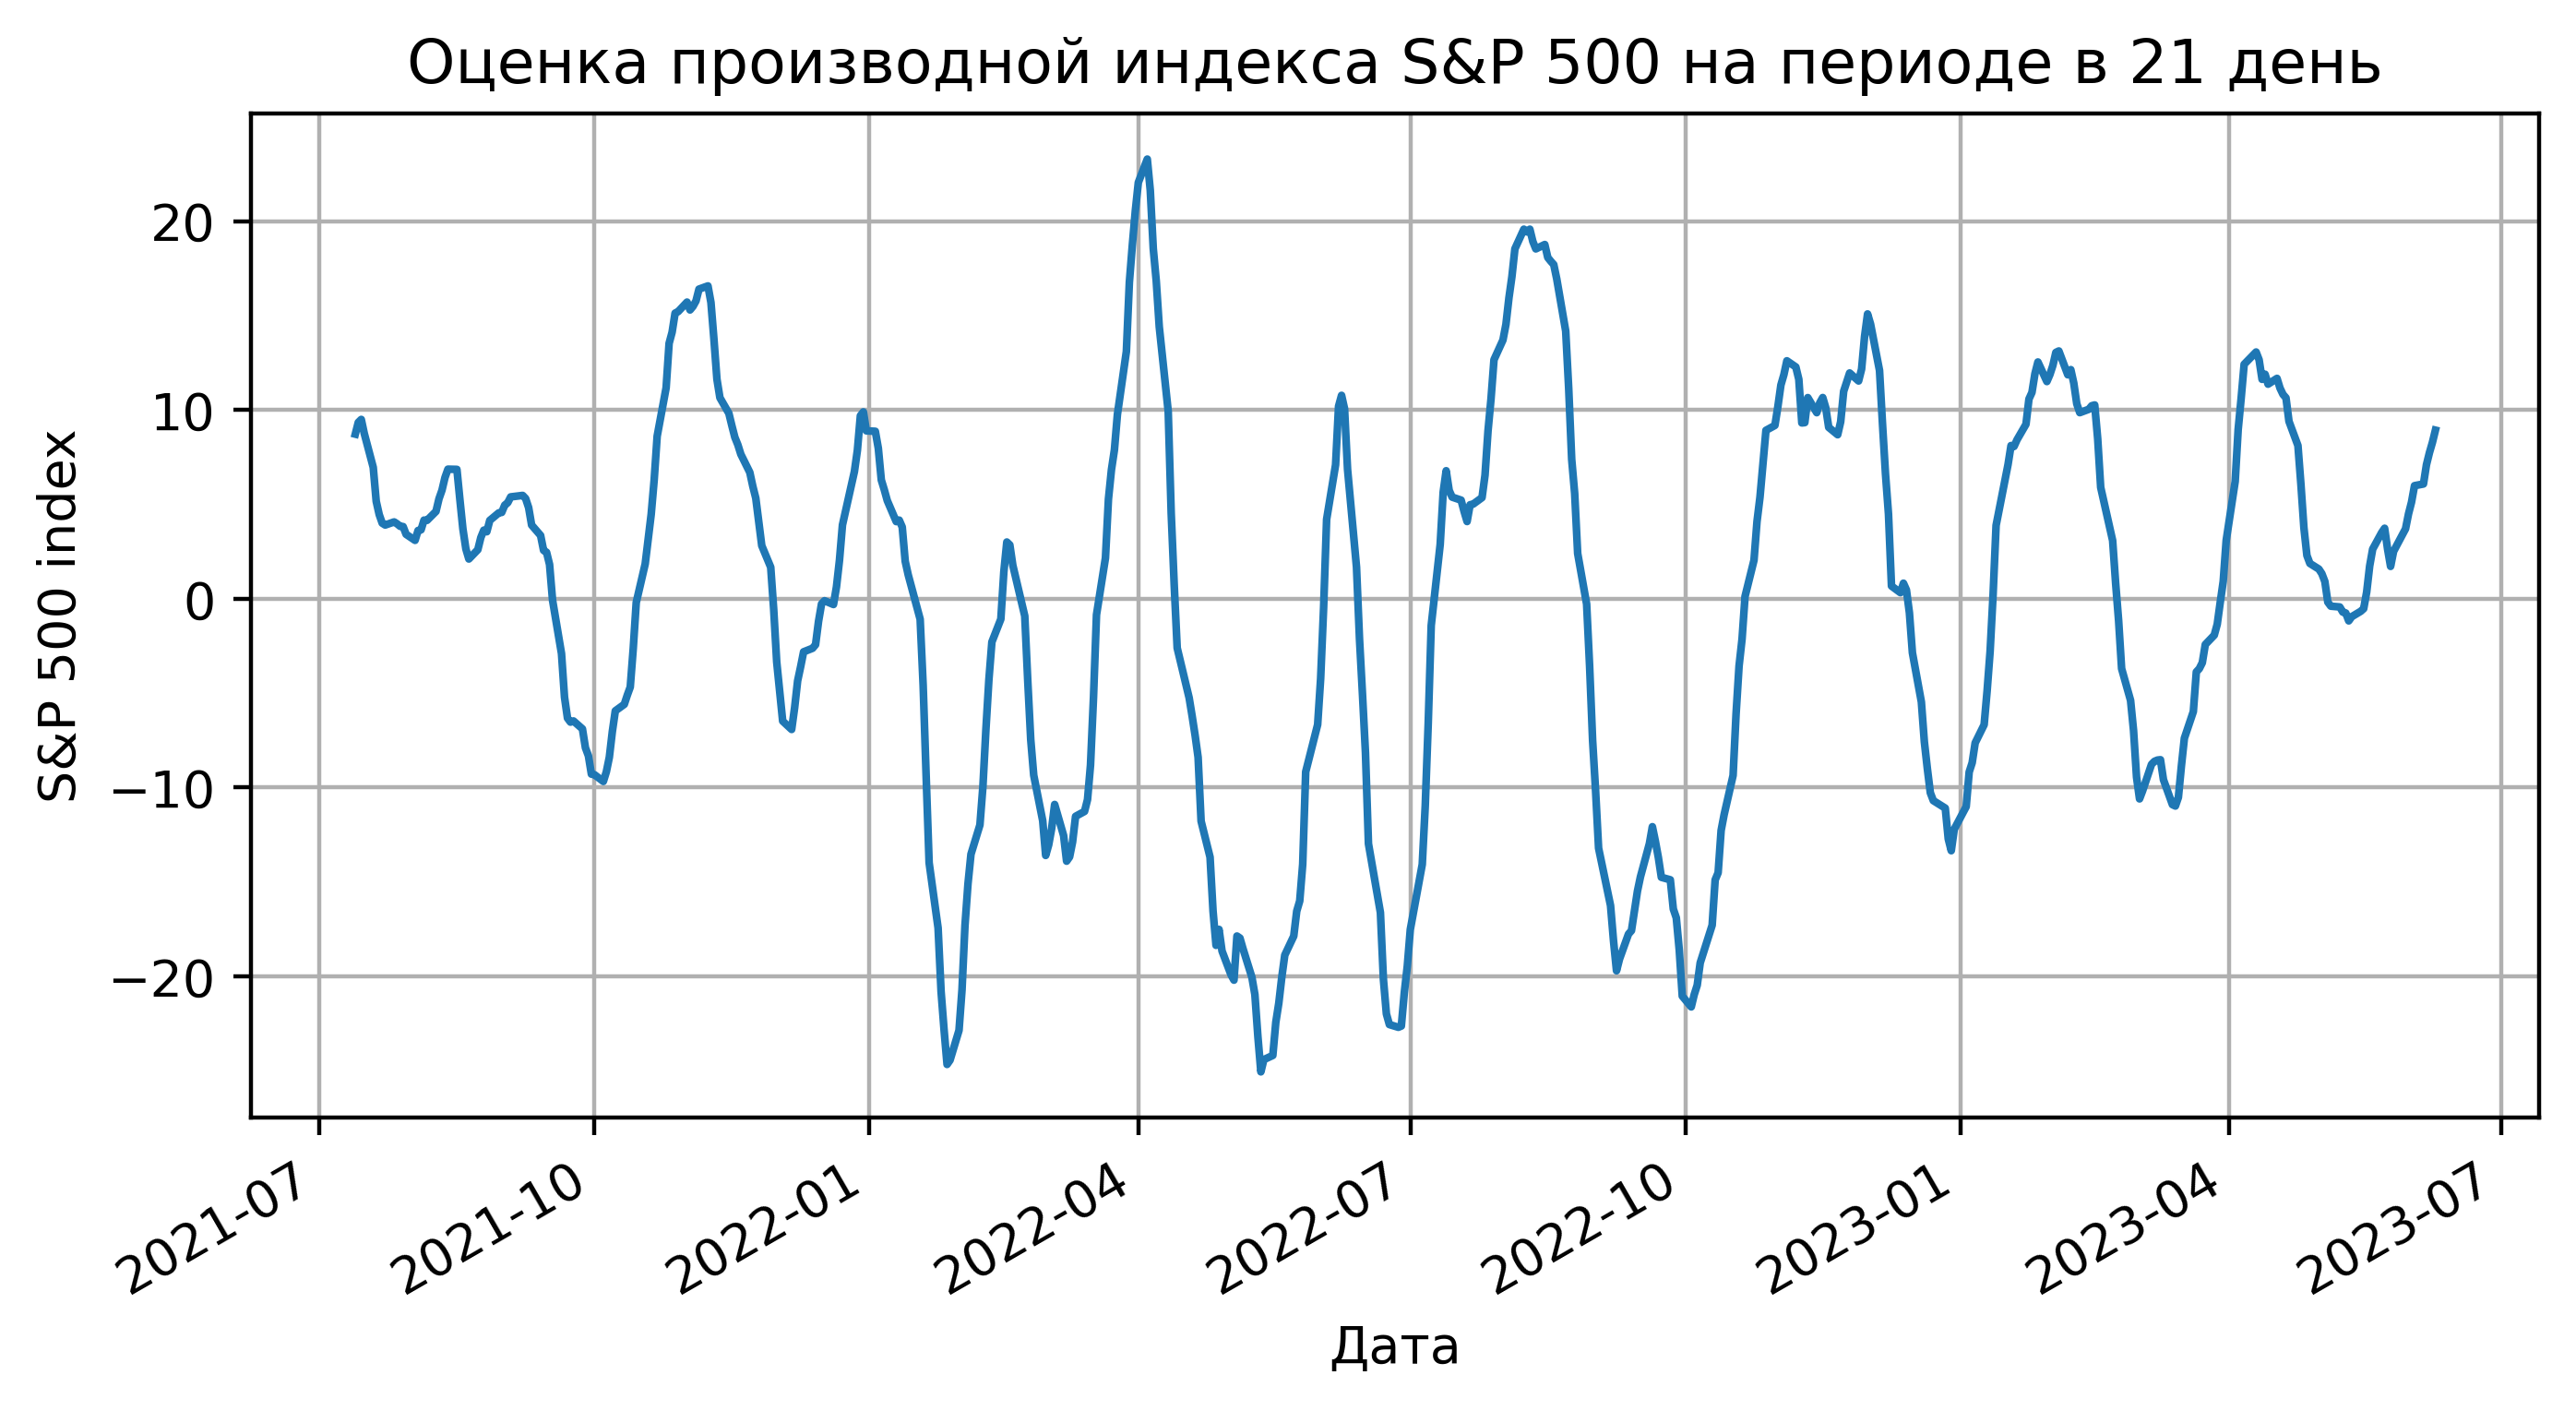

In [25]:
# оценим производную индекса в периоде 21 день 
window = 21
df_price['reg_' + sp_ticker] = df_price[sp_ticker].rolling(window = window).apply(optimal_fit)
df_price['reg_' + sp_ticker].plot(figsize=(8, 4))
plt.xlabel('Дата')
plt.ylabel('S&P 500 index')
plt.title('Оценка производной индекса S&P 500 на периоде в 21 день')
plt.grid()
plt.show()

In [26]:
# выделим 5 непересекающихся временных интервалов, когда индекс имел минимальную оценку производной
num_inter = 5
list_df_decrease = []
moments = []

df_filtered = df_price.copy()

for i in range(num_inter):
    start_date = df_filtered['reg_' + sp_ticker].idxmin()
    moments.append(start_date)
    beg_date = start_date + timedelta(days = -window - 1) 
    end_date = start_date + timedelta(days = window) 
    
    print('Период #', i, ' : ', start_date, " - ", end_date, 
          ', оценка убывания : ', df_filtered.loc[start_date]['reg_' + sp_ticker])
    
    temp_df = pd.DataFrame()
    temp_df = pd.concat([df_price[(start_date <= df_price.index) & (df_price.index <= end_date)], temp_df]
                        , axis = 1)
    
    list_df_decrease.append(temp_df)
    df_filtered = df_filtered[(beg_date > df_filtered.index) | (df_filtered.index > end_date)]

Период # 0  :  2022-05-12 00:00:00  -  2022-06-02 00:00:00 , оценка убывания :  -25.057582310267758
Период # 1  :  2022-01-27 00:00:00  -  2022-02-17 00:00:00 , оценка убывания :  -24.66525086241891
Период # 2  :  2022-06-27 00:00:00  -  2022-07-18 00:00:00 , оценка убывания :  -22.69701546012578
Период # 3  :  2022-10-03 00:00:00  -  2022-10-24 00:00:00 , оценка убывания :  -21.61820908583614
Период # 4  :  2022-09-08 00:00:00  -  2022-09-29 00:00:00 , оценка убывания :  -19.704603794642956


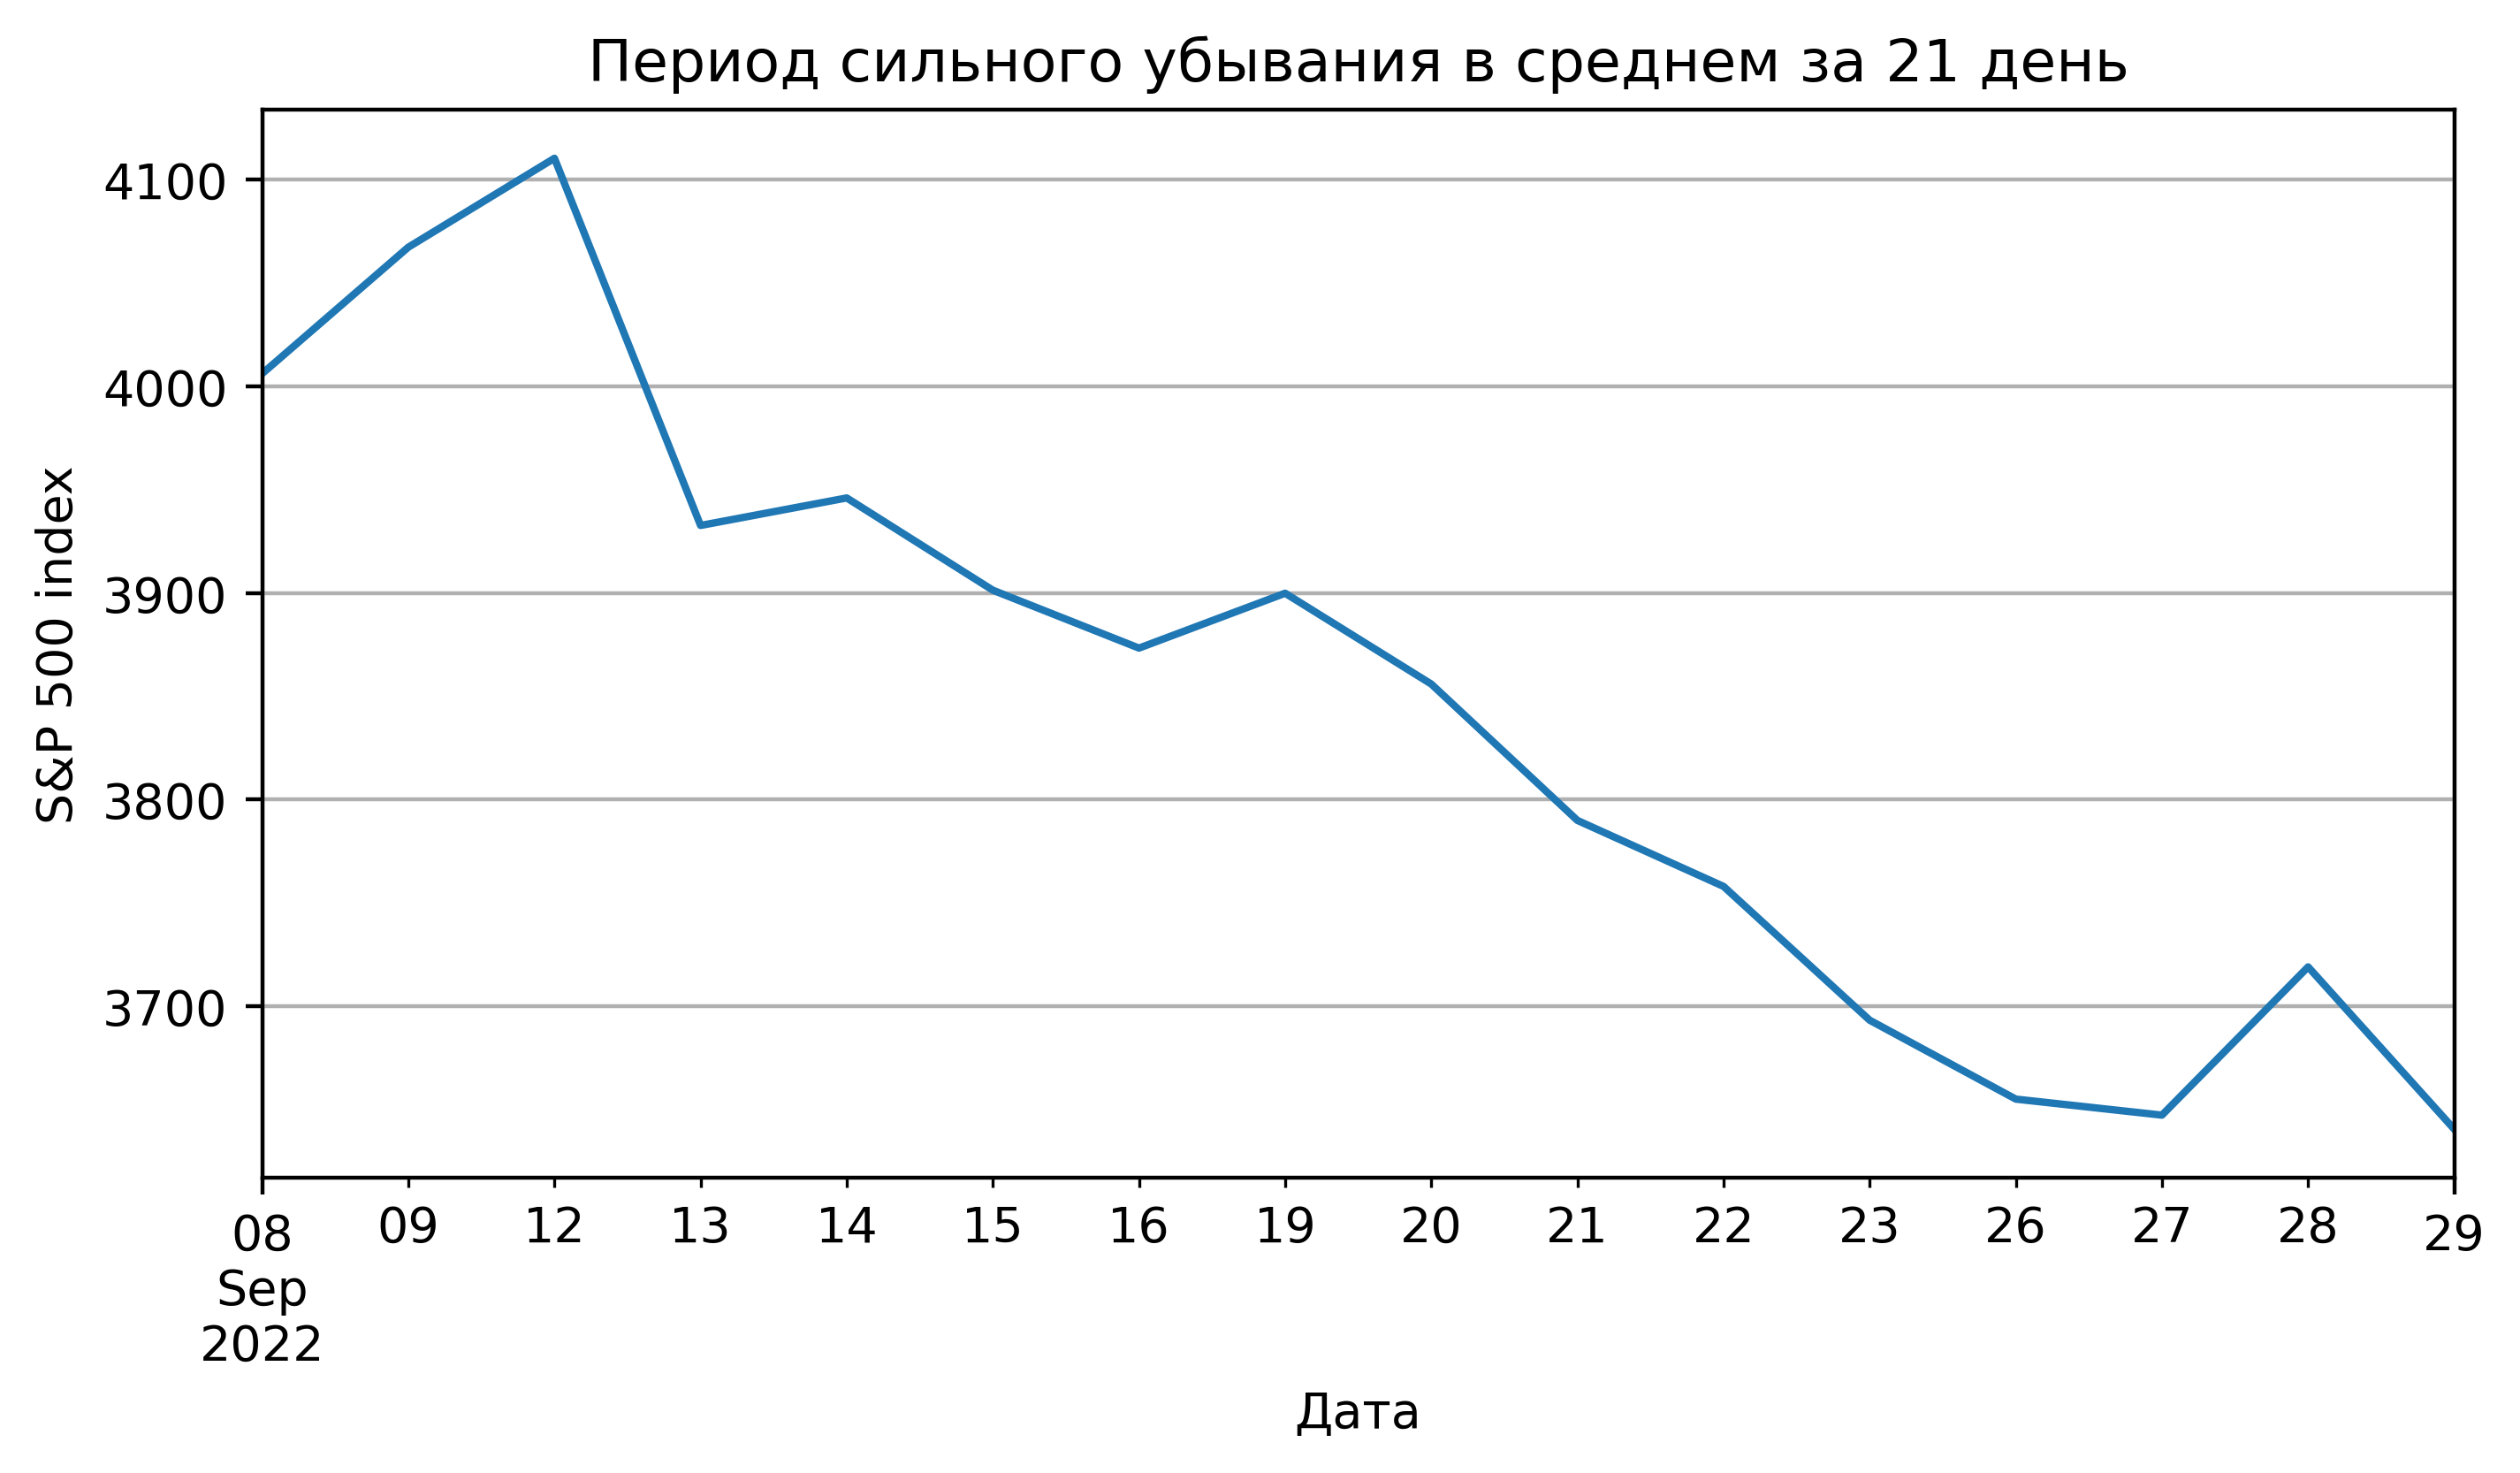

In [36]:
# пример отрезка, из построенных выше моментов, где индекс сильно убывает
# зафиксируем, например, четвёртый интервал, и далее будем работать только с ним

selected_interval = 4

assert(selected_interval < num_inter)

list_df_decrease[selected_interval][sp_ticker].plot(figsize=(8, 4))
plt.xlabel('Дата')
plt.ylabel('S&P 500 index')
plt.title('Период сильного убывания в среднем за 21 день')
plt.grid()

In [37]:
# теперь пройдёмся по каждой из 500 компаний и определим топ 3, которые наиболее выросли
# в период падения индекса S&P 500, т.е. в момент "медвежьего" рынка
# для этого оценим скорость роста фукнцией optimal_fit, которая написана выше

num_top = 3
list_top_comp = []

for df_elem in list_df_decrease:
    growth_for_company = df_elem.apply(optimal_fit, axis = 0)
    top_comp = list(growth_for_company.nlargest(num_top).index)
    list_top_comp.append(top_comp)
    
    if sp_ticker in top_comp:
        top_comp.remove(sp_ticker) # удаляем S&P 500, если он присутствует
    print(top_comp)

['BKNG', 'NVR']
['BKNG', 'CMG', 'MPWR']
['NVR', 'AZO', 'ORLY']
['AZO', 'BKNG', 'LMT']
['BIIB', 'HUM', 'LLY']


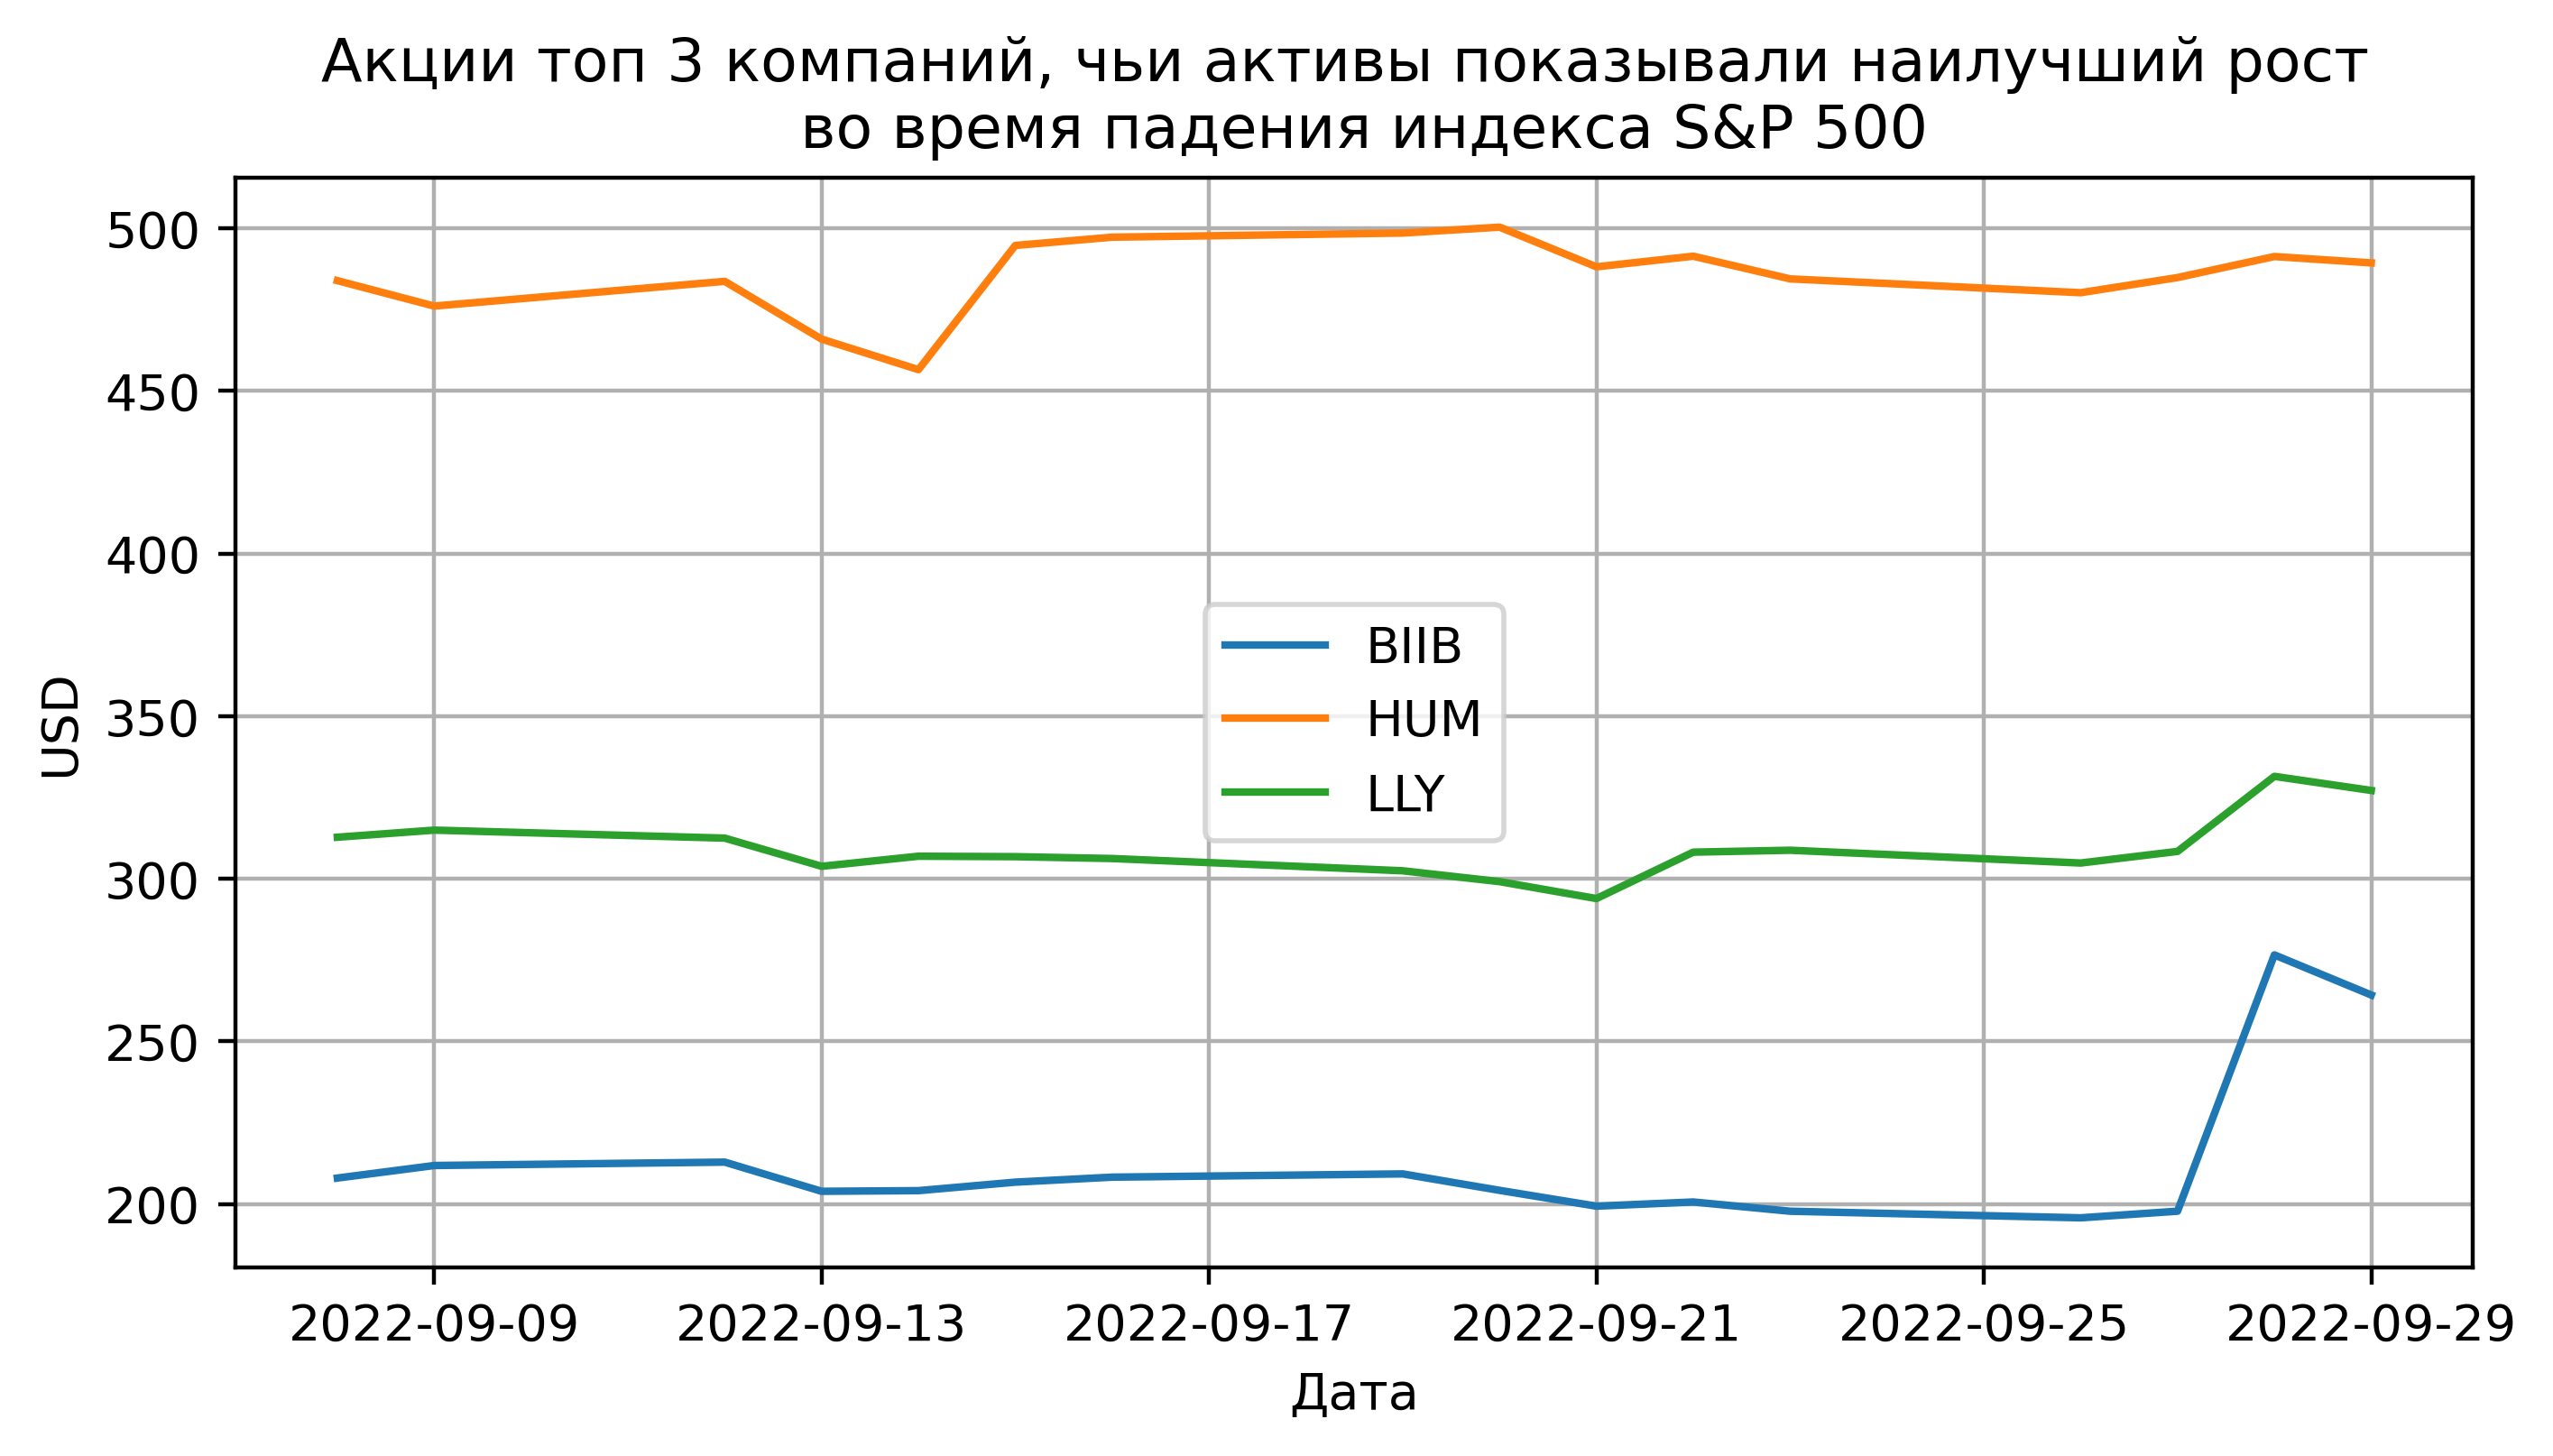

In [38]:
# построим график акций топовых компаний, которые росли в момент падения

assert(selected_interval < num_inter)

fig, ax = plt.subplots(figsize = (8, 4))

for comp in list_top_comp[selected_interval]:
    ax.plot(list_df_decrease[selected_interval][comp].index,
            list_df_decrease[selected_interval][comp],
            label = comp)
    
ax.set_xlabel('Дата')
ax.set_ylabel('USD')
ax.legend(loc='best')
plt.title('Акции топ ' + str(num_top) + ' компаний, чьи активы показывали наилучший рост \n во время падения индекса S&P 500')
plt.grid()
plt.show()

**Заключение**

В рамках проекта были активно использованы многие фукнции и классы различных библиотек. Все графики и анализ, описанные в введении, построены в полном объёме. 